# Cosine Similarity, Clustering and Phylogeny
- Cosine Similarity is a metric used to measure the similarity between two vectors by calculating the cosine of the angle between them. It is commonly used in text analysis,  information retrieval to determine the similarity between featute vectors.

- Clustering refers to the process of grouping similar data points together based on their characteristics or similarity measures. It is an unsupervised learning technique used to discover inherent patterns or structures in data. Clustering algorithms, such as k-means or hierarchical clustering, are employed to partition data into distinct groups or clusters.

- Phylogeny deals with the evolutionary relationships among organisms. It aims to reconstruct the evolutionary history of species or genes by analyzing their genetic or molecular data. Phylogenetic analysis uses algorithms and methods to construct phylogenetic trees, which represent the evolutionary relationships and branching patterns between different organisms or genetic sequences.

- In this work, we employ a combination of these techniques to gain insights into the relationships among 16s bacterial sequences without necessarily aligning the sequences. This work is a continuation of previous work that began by calculating the average cosine similarity. Next, we are adding the categories of the cosine similarities to each sequence. We then  leverage one hot encoding to transform the categorical information derived from the cosine average similarity scores. This encoding scheme enables us to represent the similarity information in a format suitable for further analysis. Subsequently, we utilize hierarchical clustering to construct a dendrogram, which visually represents the grouping of similar sequences based on their similarity scores. 
- Extracting the Newick format from the dendrogram provides us with a concise representation of the evolutionary relationships among the sequences. By integrating cosine similarity, one hot encoding, clustering, and phylogeny, we aim to unravel the underlying patterns and evolutionary connections among biological entities, thereby contributing to our understanding of the complex world of biology.

## Run the workflow in one go using a Makefile

In [1]:
!make run_script

# run script: load fasta, create sequence_metrics
# calculate cosine similiarity averages
python multifastaloader.py
python load_multifasta_metrics.py
python tokenize_compare_sequences.py
2023-07-05 12:34:47.630019: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 12:34:47.667379: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 12:34:47.667769: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 12:34:48.349647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# ## Run the tokenize_compare_sequences.py to generate the average cosine similarity metrics table for k=4,5,6,9 and character level
# ! python3 tokenize_compare_sequences.py

In [3]:
# import required libraries
import numpy as np # vector manipulation
import pandas as pd  # Library for data manipulation and analysis
from sklearn.metrics import silhouette_score  # Metric for evaluating cluster quality
from scipy.cluster.hierarchy import linkage, dendrogram,to_tree # Functions for hierarchical clustering
from sklearn.cluster import AgglomerativeClustering  # Class for performing agglomerative clustering
import matplotlib.pyplot as plt  # Library for creating plots and visualizations
from IPython.display import Image  # Library for displaying images in Jupyter notebooks


In [4]:
def get_newick(node, leaf_names, leaf_distances):
    """
    Recursively constructs the Newick format string for a given node in the hierarchical clustering tree.

    Parameters:
    ----------
    node (scipy.cluster.hierarchy.ClusterNode): The current node in the tree.
    leaf_names (list): A list of the names of the leaf nodes.
    leaf_distances (list): A list of the distances between the leaf nodes.

    Returns:
    -------
    str: The Newick format string for the given node.

    Example:
    -------
    >>> get_newick(tree, y.values, leaf_distances)
    """
    if node.is_leaf():
        return f"{leaf_names[node.id]}:{leaf_distances[node.id]}"
    else:
        left_child = get_newick(node.left, leaf_names, leaf_distances)
        right_child = get_newick(node.right, leaf_names, leaf_distances)
        return f"({left_child},{right_child}):{node.dist}"

def read_kmer_matrix_file(csv_file):
    '''
    Read the kmer matrix file and return the dataframe
    
    Parameters:
    ----------
    csv_file (str): The path to the csv file.
    
    Returns:
    -------
    df: The dataframe containing the kmer matrix.
    newick: The Newick format string for the given node.
    
    Example:
    -------
    >>> read_kmer_matrix_file('kmer_matrix.csv')
    
    '''
    # read csv file
    df_cosine = pd.read_csv(csv_file)

    # Convert similarity matrix to a dictionary
    similarity_ranges = {
        (0.0, 0.2): "low similarity",
        (0.2, 0.4): "moderate similarity",
        (0.4, 0.6): "high similarity",
        (0.6, 0.8): "very high similarity",
        (0.8, 1.0): "identical sequences"
    }

    # Add the cosine category to each sequence
    df_cosine['cosine_category'] = df_cosine['cosine_similarity_average'].apply(
        lambda x: next((code for similarity_range, code in similarity_ranges.items()
                        if similarity_range[0] < x <= similarity_range[1]), None))

    # Perform one-hot encoding on the 'cosine_category' column
    one_hot_encoded = pd.get_dummies(df_cosine['cosine_category'])

    # Concatenate the one-hot encoded columns with the original DataFrame
    df_encoded = pd.concat([df_cosine, one_hot_encoded], axis=1)

    # Extract label column
    y = df_encoded["accession_id"]
    X = df_encoded.drop(columns=["accession_id", "cosine_category", "label_encoded"])

    # Perform hierarchical clustering: centroid linkage
    linkage_matrix = linkage(X, method='centroid')

    # Plot the dendrogram
    plt.figure(figsize=(10, 15))  # Adjust the figure size to increase the height
    # adjust the text size
    plt.rcParams.update({'font.size': 10})
    # make a horizontal dendrogram: makes it easier to see terminal nodes
    dendrogram(linkage_matrix, labels=y.values, orientation='right', leaf_font_size=10)
    plt.xlabel('Distance')
    plt.ylabel('Samples')
    plt.title('Dendrogram')
    plt.show()

    # Convert dendrogram to a tree structure
    tree = to_tree(linkage_matrix)

    # Extract Newick format from the tree
    leaf_distances = np.zeros(len(y))
    newick = get_newick(tree, y.values, leaf_distances)

    # Determine the optimal number of clusters based on the data
    silhouette_scores = []
    max_clusters = min(10, len(X) - 1)  # Set the maximum number of clusters as a safeguard
    for n_clusters in range(2, max_clusters + 1):
        model = AgglomerativeClustering(n_clusters=n_clusters)
        clusters = model.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, clusters))

    optimal_num_clusters = np.argmax(silhouette_scores) + 2  # Add 2 to get the actual number of clusters

    # Perform agglomerative clustering with the optimal number of clusters
    model = AgglomerativeClustering(n_clusters=optimal_num_clusters)
    clusters = model.fit_predict(X)

    # Add cluster labels to the DataFrame
    df_encoded['Cluster'] = clusters

    return df_encoded, newick




# Clustering for kmer =6
The diagram below shows the dendogra, obtained from the cosine similarity metric categories. To visualize th clustering,  the dendogram is used to generate newick tree file. The newick tree file is was visualized using phylo.io and the equivalent phylogenetics tree is shown. 

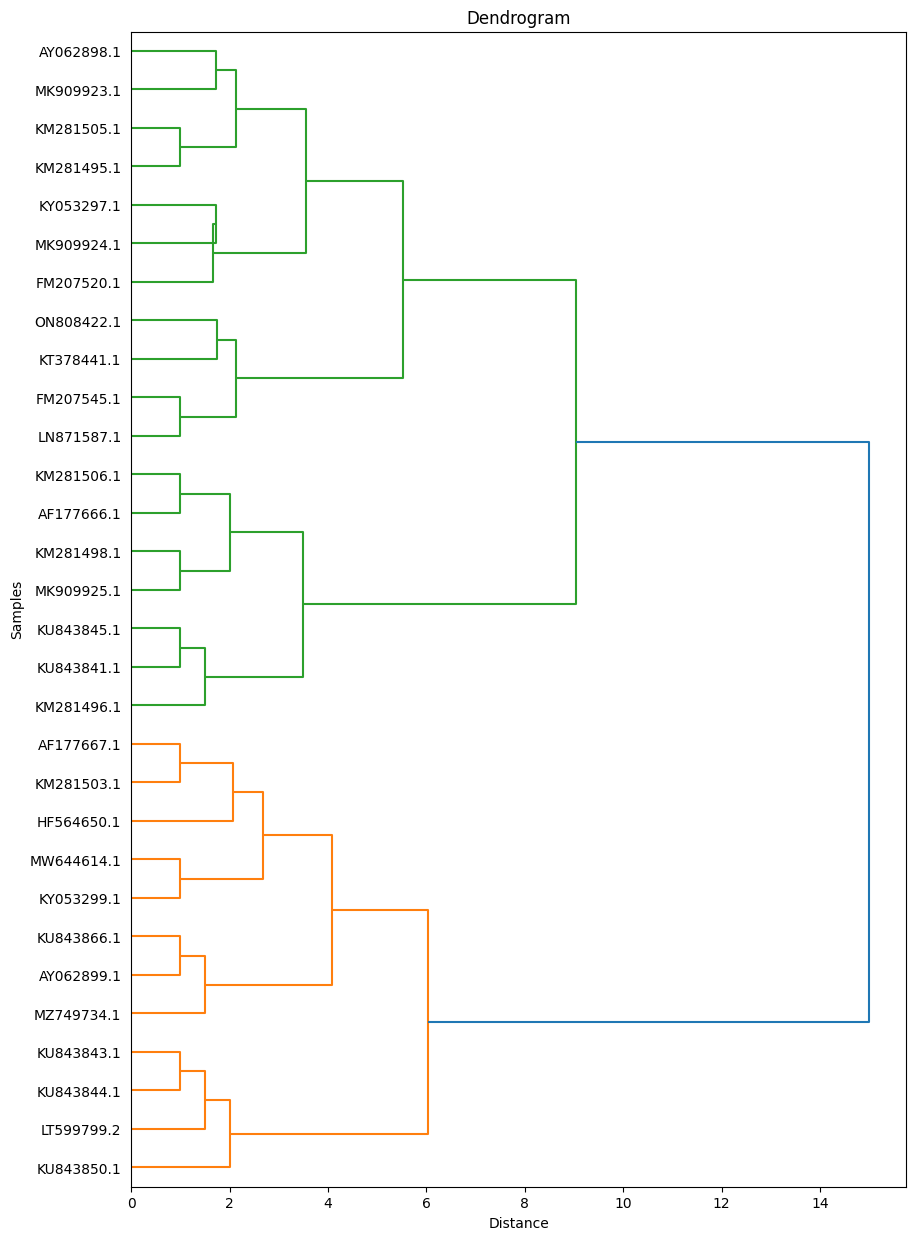

In [5]:
# Results for kmer =6
data, newick_format_6_kmer = read_kmer_matrix_file("updated_data/cosine_similarity_6_mer.csv")


Note the object newick_format_6_kmer was uploaded without the quotation marks to phylo.io to generate the image below.

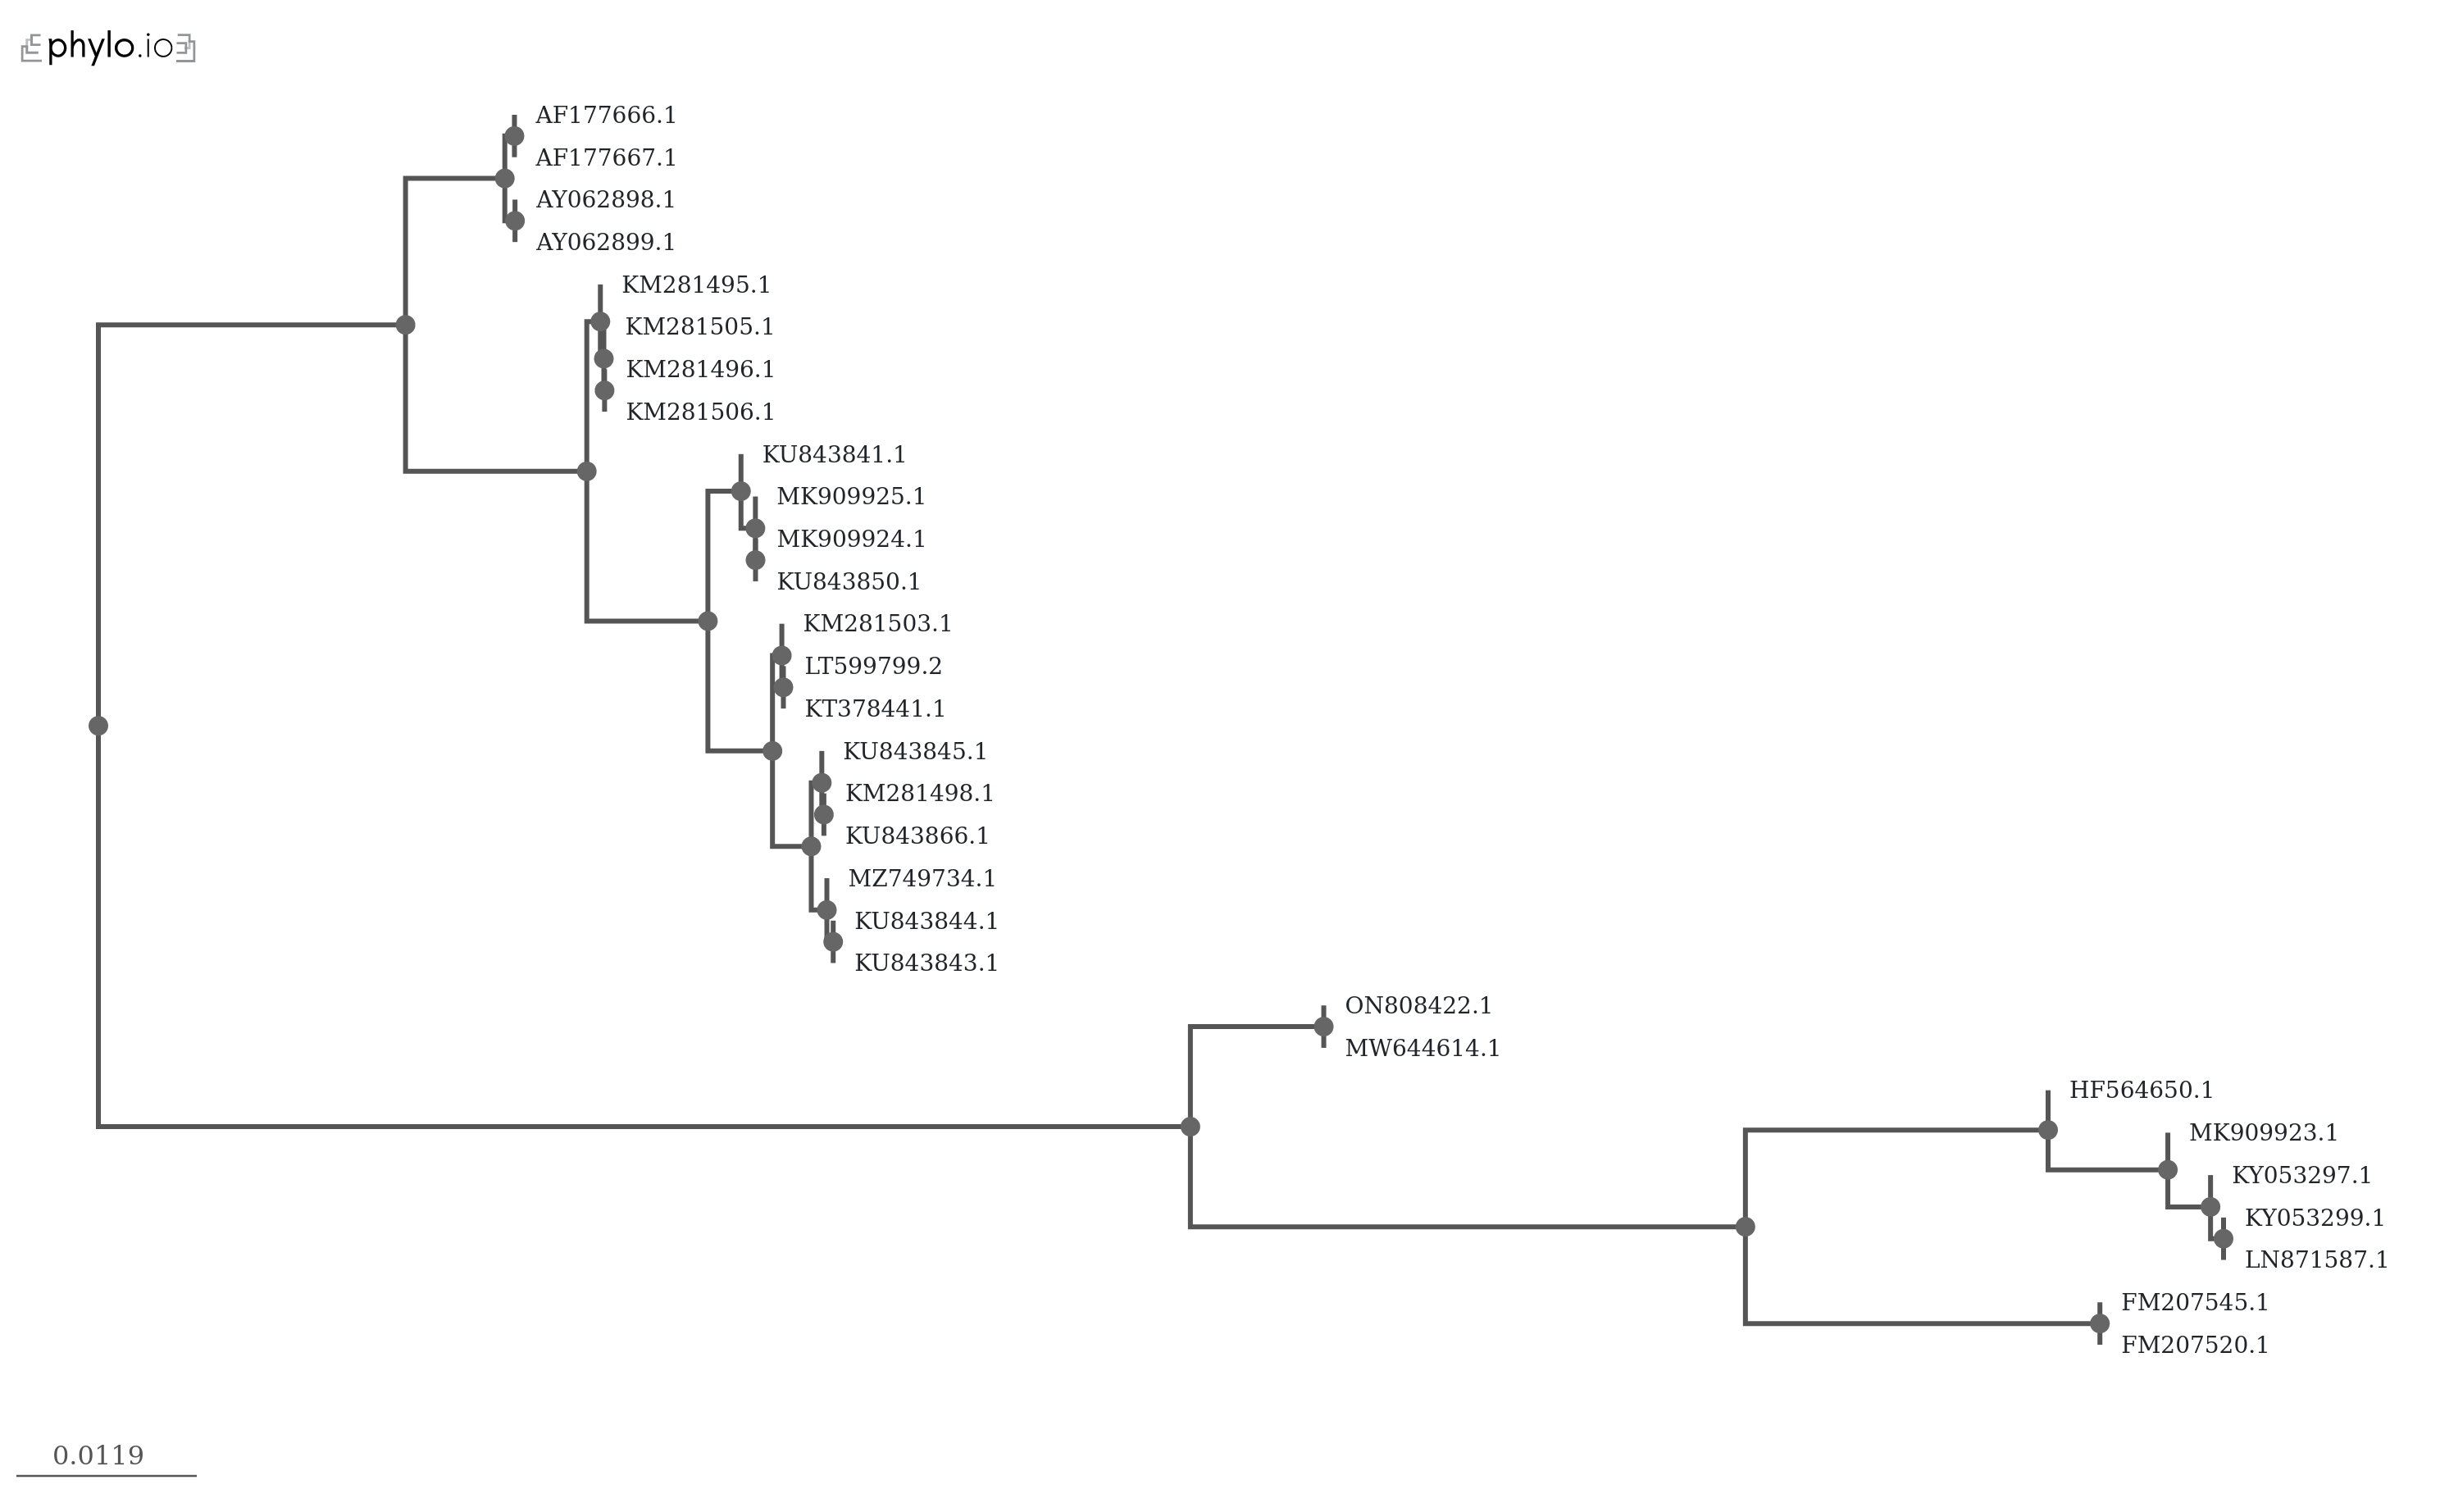

In [6]:
# Visualize the newick equivalent of the dendogram. The newick from above tree was visualized in phylo.io
image_path = "./images/cosine_similarity/6kmer_tree.png"
Image(filename=image_path)


<!-- From above clustering, we can see that sample sequnces of the closely relate species species are found clustering together. 
- AF177667.1 Bordetella hinzii  and AF177666.1 Bordetella avium  16S ribosomal RNA geneare are in the same clade. 
- AY062898.1 Helicobacter pylori strain 108 16S ribosomal RNA gene and AY062899.1 Helicobacter pylori strain 109  are on the same clade
- KM281495.1 Acinetobacter calcoaceticus strain 364, KM281496.1 Acinetobacter baumannii strain 313,KM281505.1 Acinetobacter parvus strain 227, -->


<!-- Some related species genes are still clustering in different clades. We could try to fine tune kmers or another featuere tha can increase the refinement of the clustering -->

# kmer 5 clustering

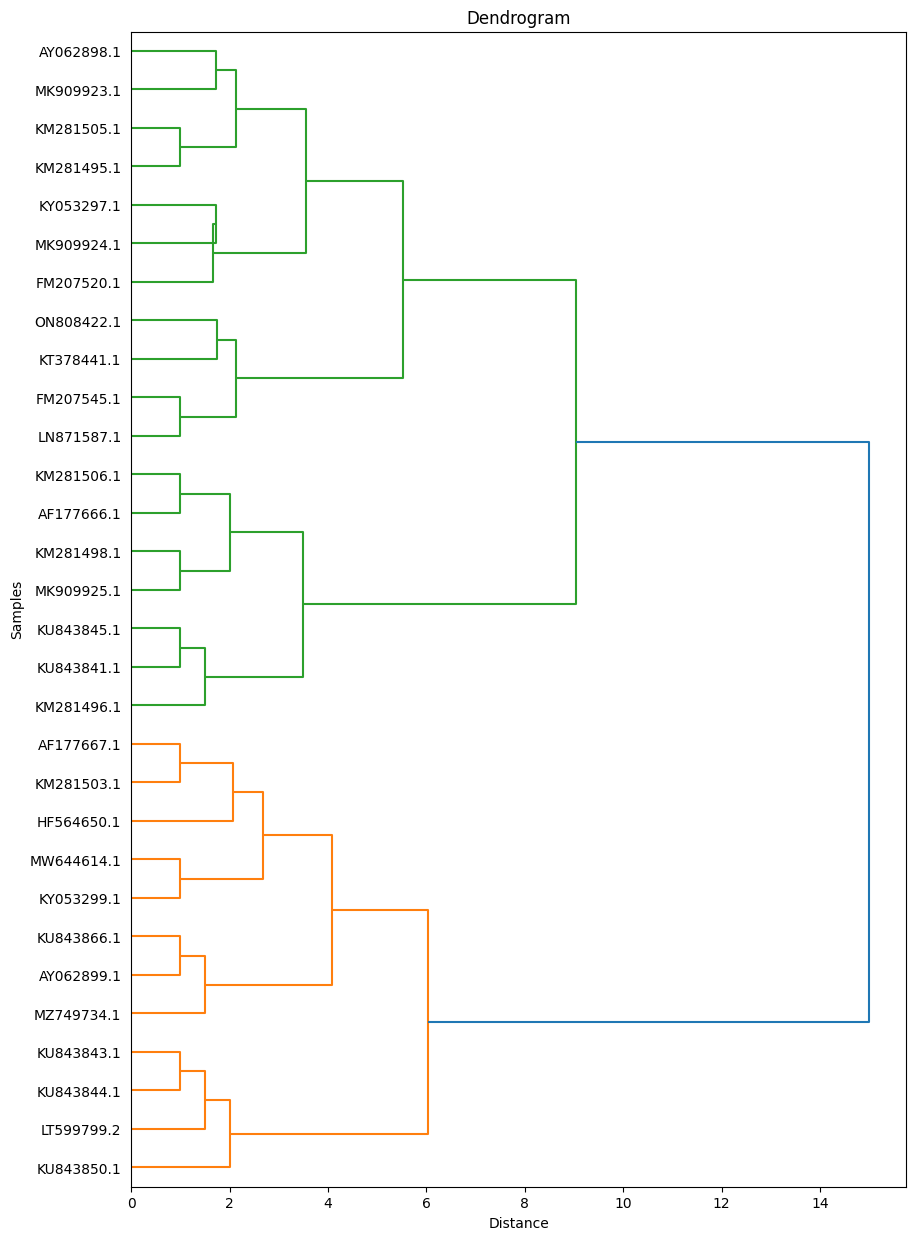

In [7]:
# Results for kmer = 5
data, newick_format_6_kmer = read_kmer_matrix_file("updated_data/cosine_similarity_6_mer.csv")


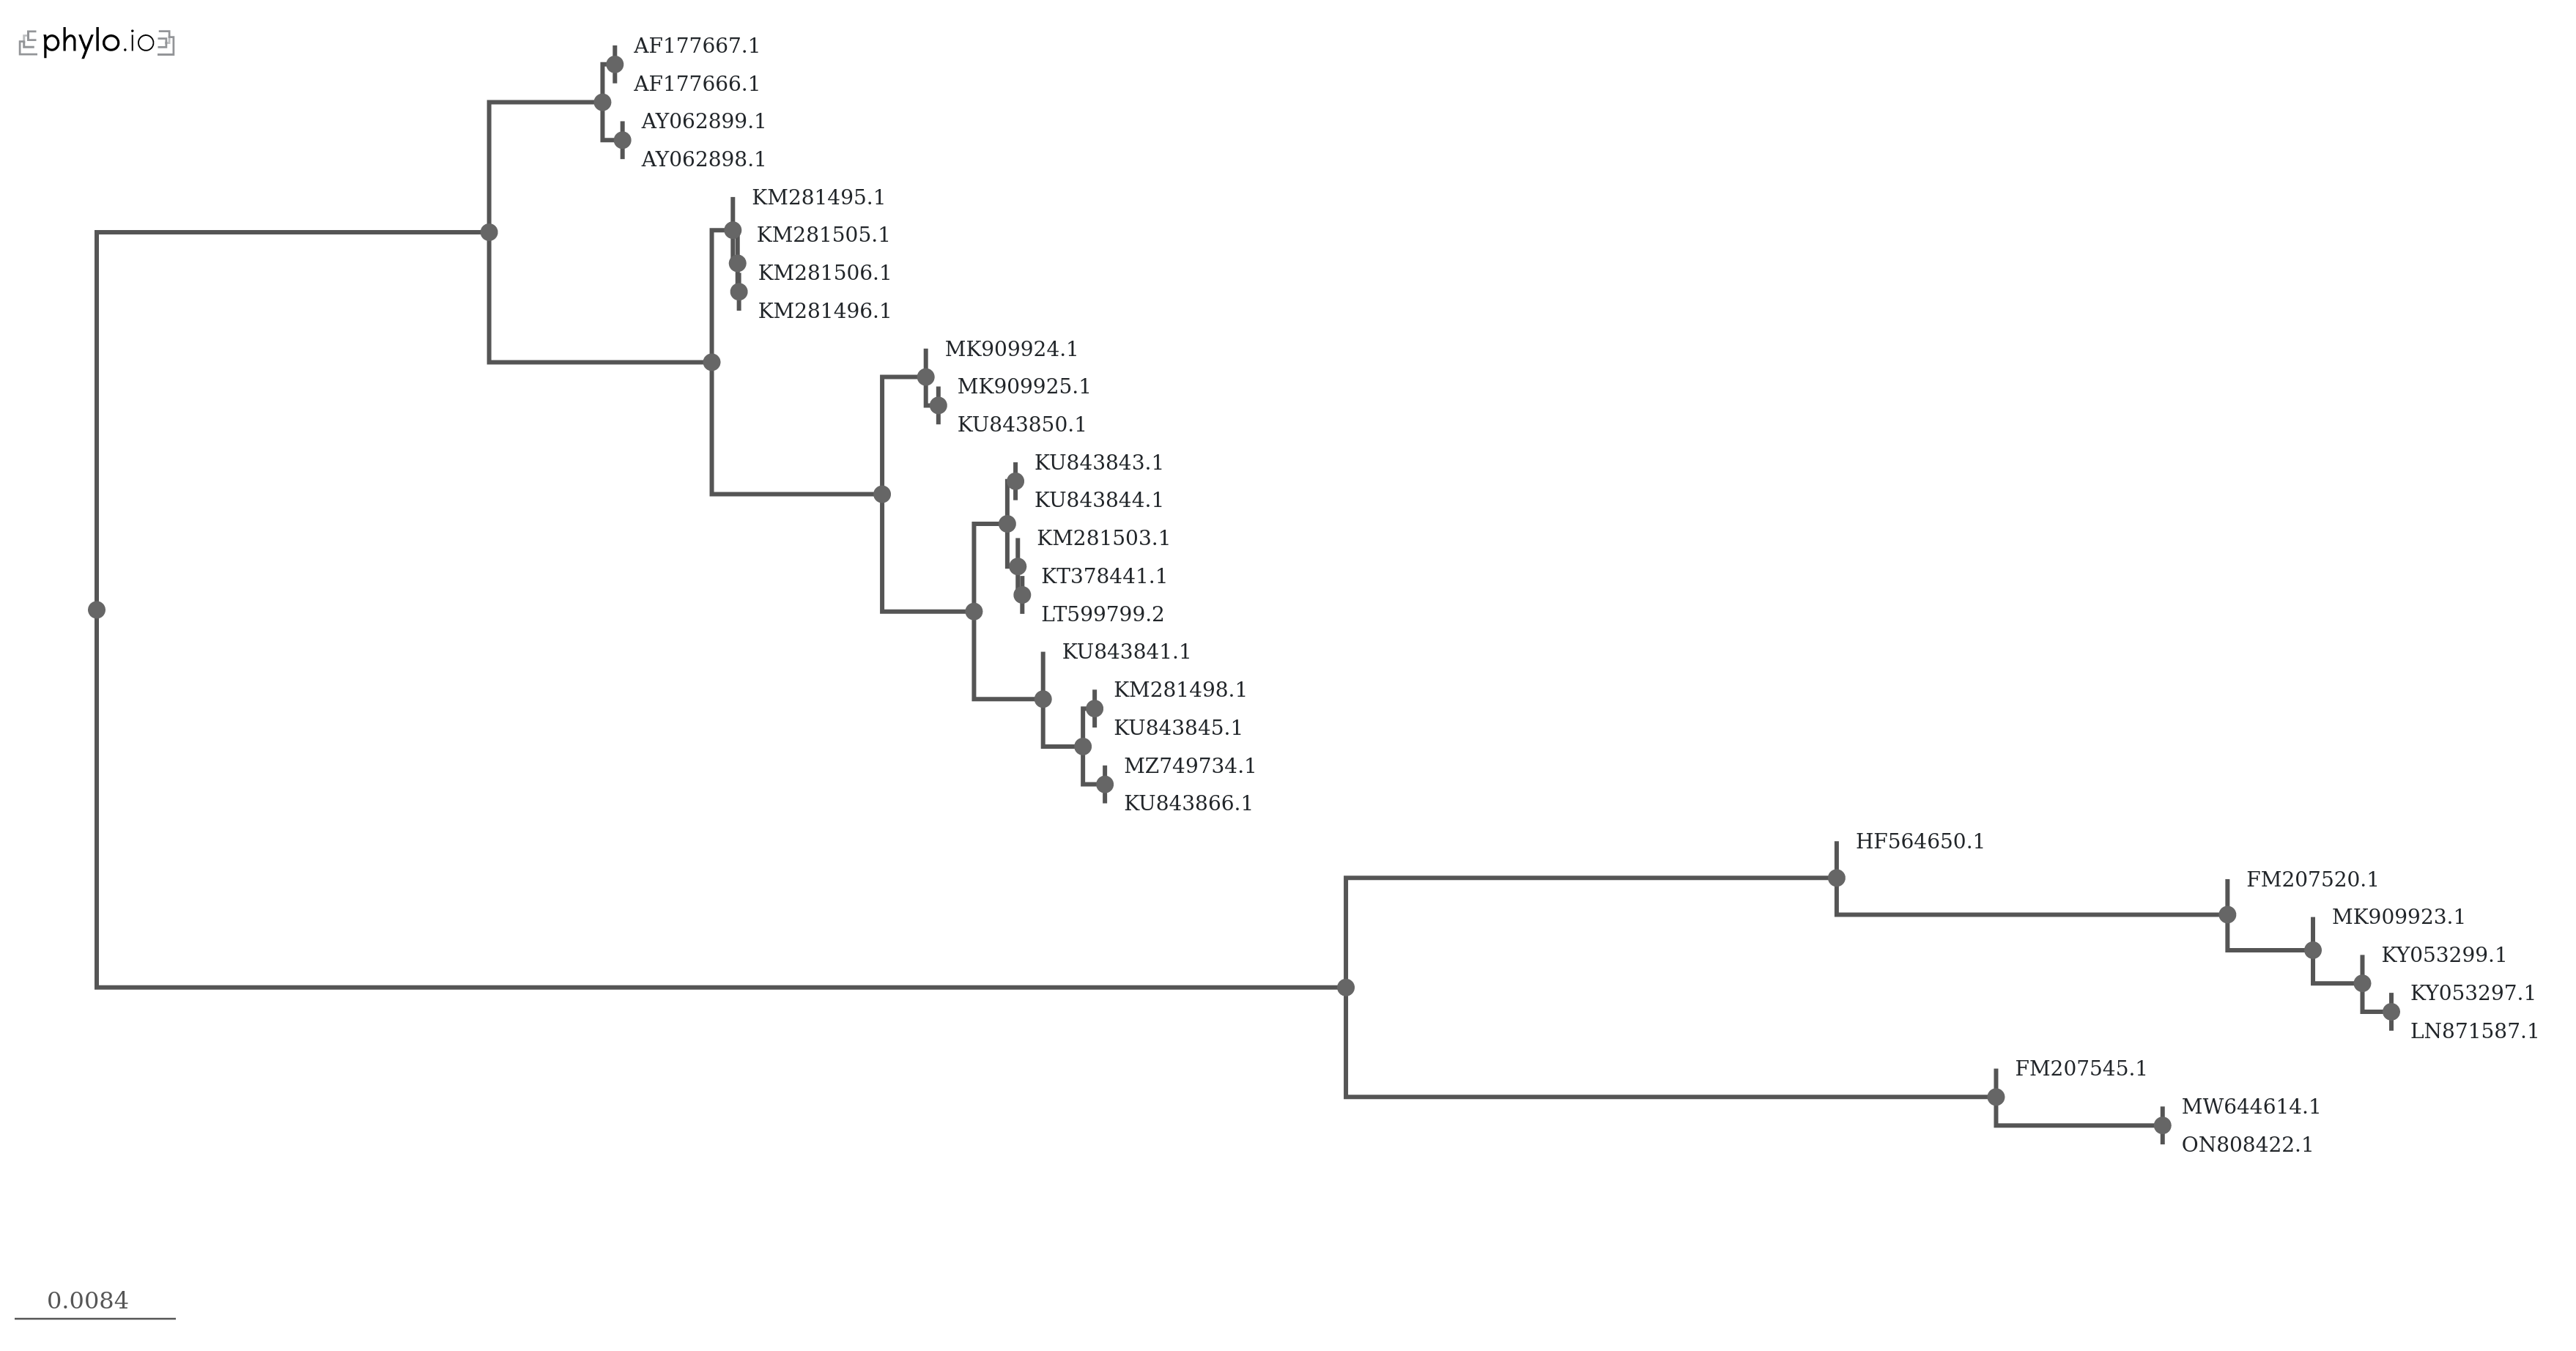

In [8]:
# Visualize the newick equivalent of tyhe dendogram. The newick from above tree was visualizd in phylo.io
image_path = "./images/cosine_similarity/5Kmer_tree.png"
Image(filename=image_path)

# Results for kmer = 4


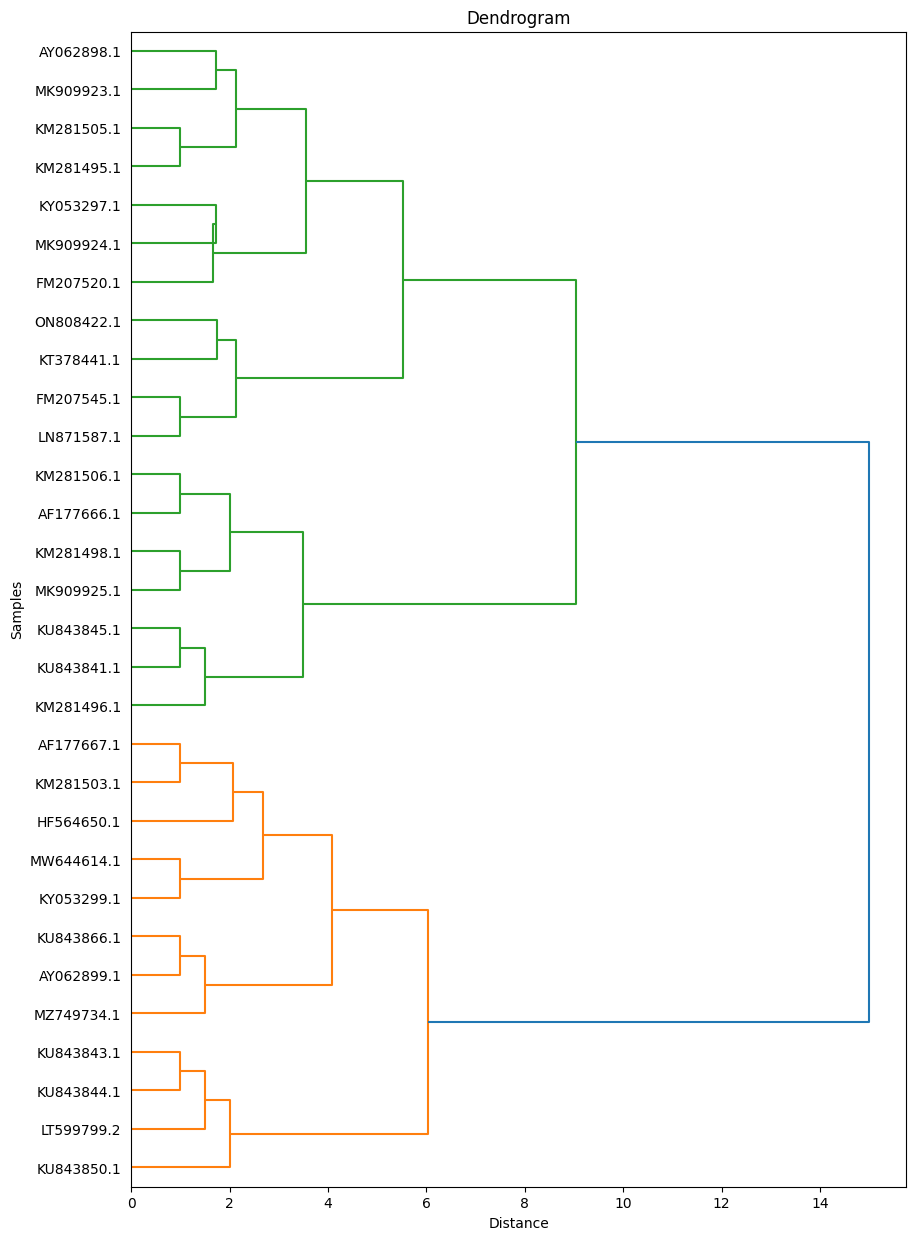

In [9]:
# Results for kmer = 4
data, newick_format_4_kmer = read_kmer_matrix_file("updated_data/cosine_similarity_4_mer.csv")


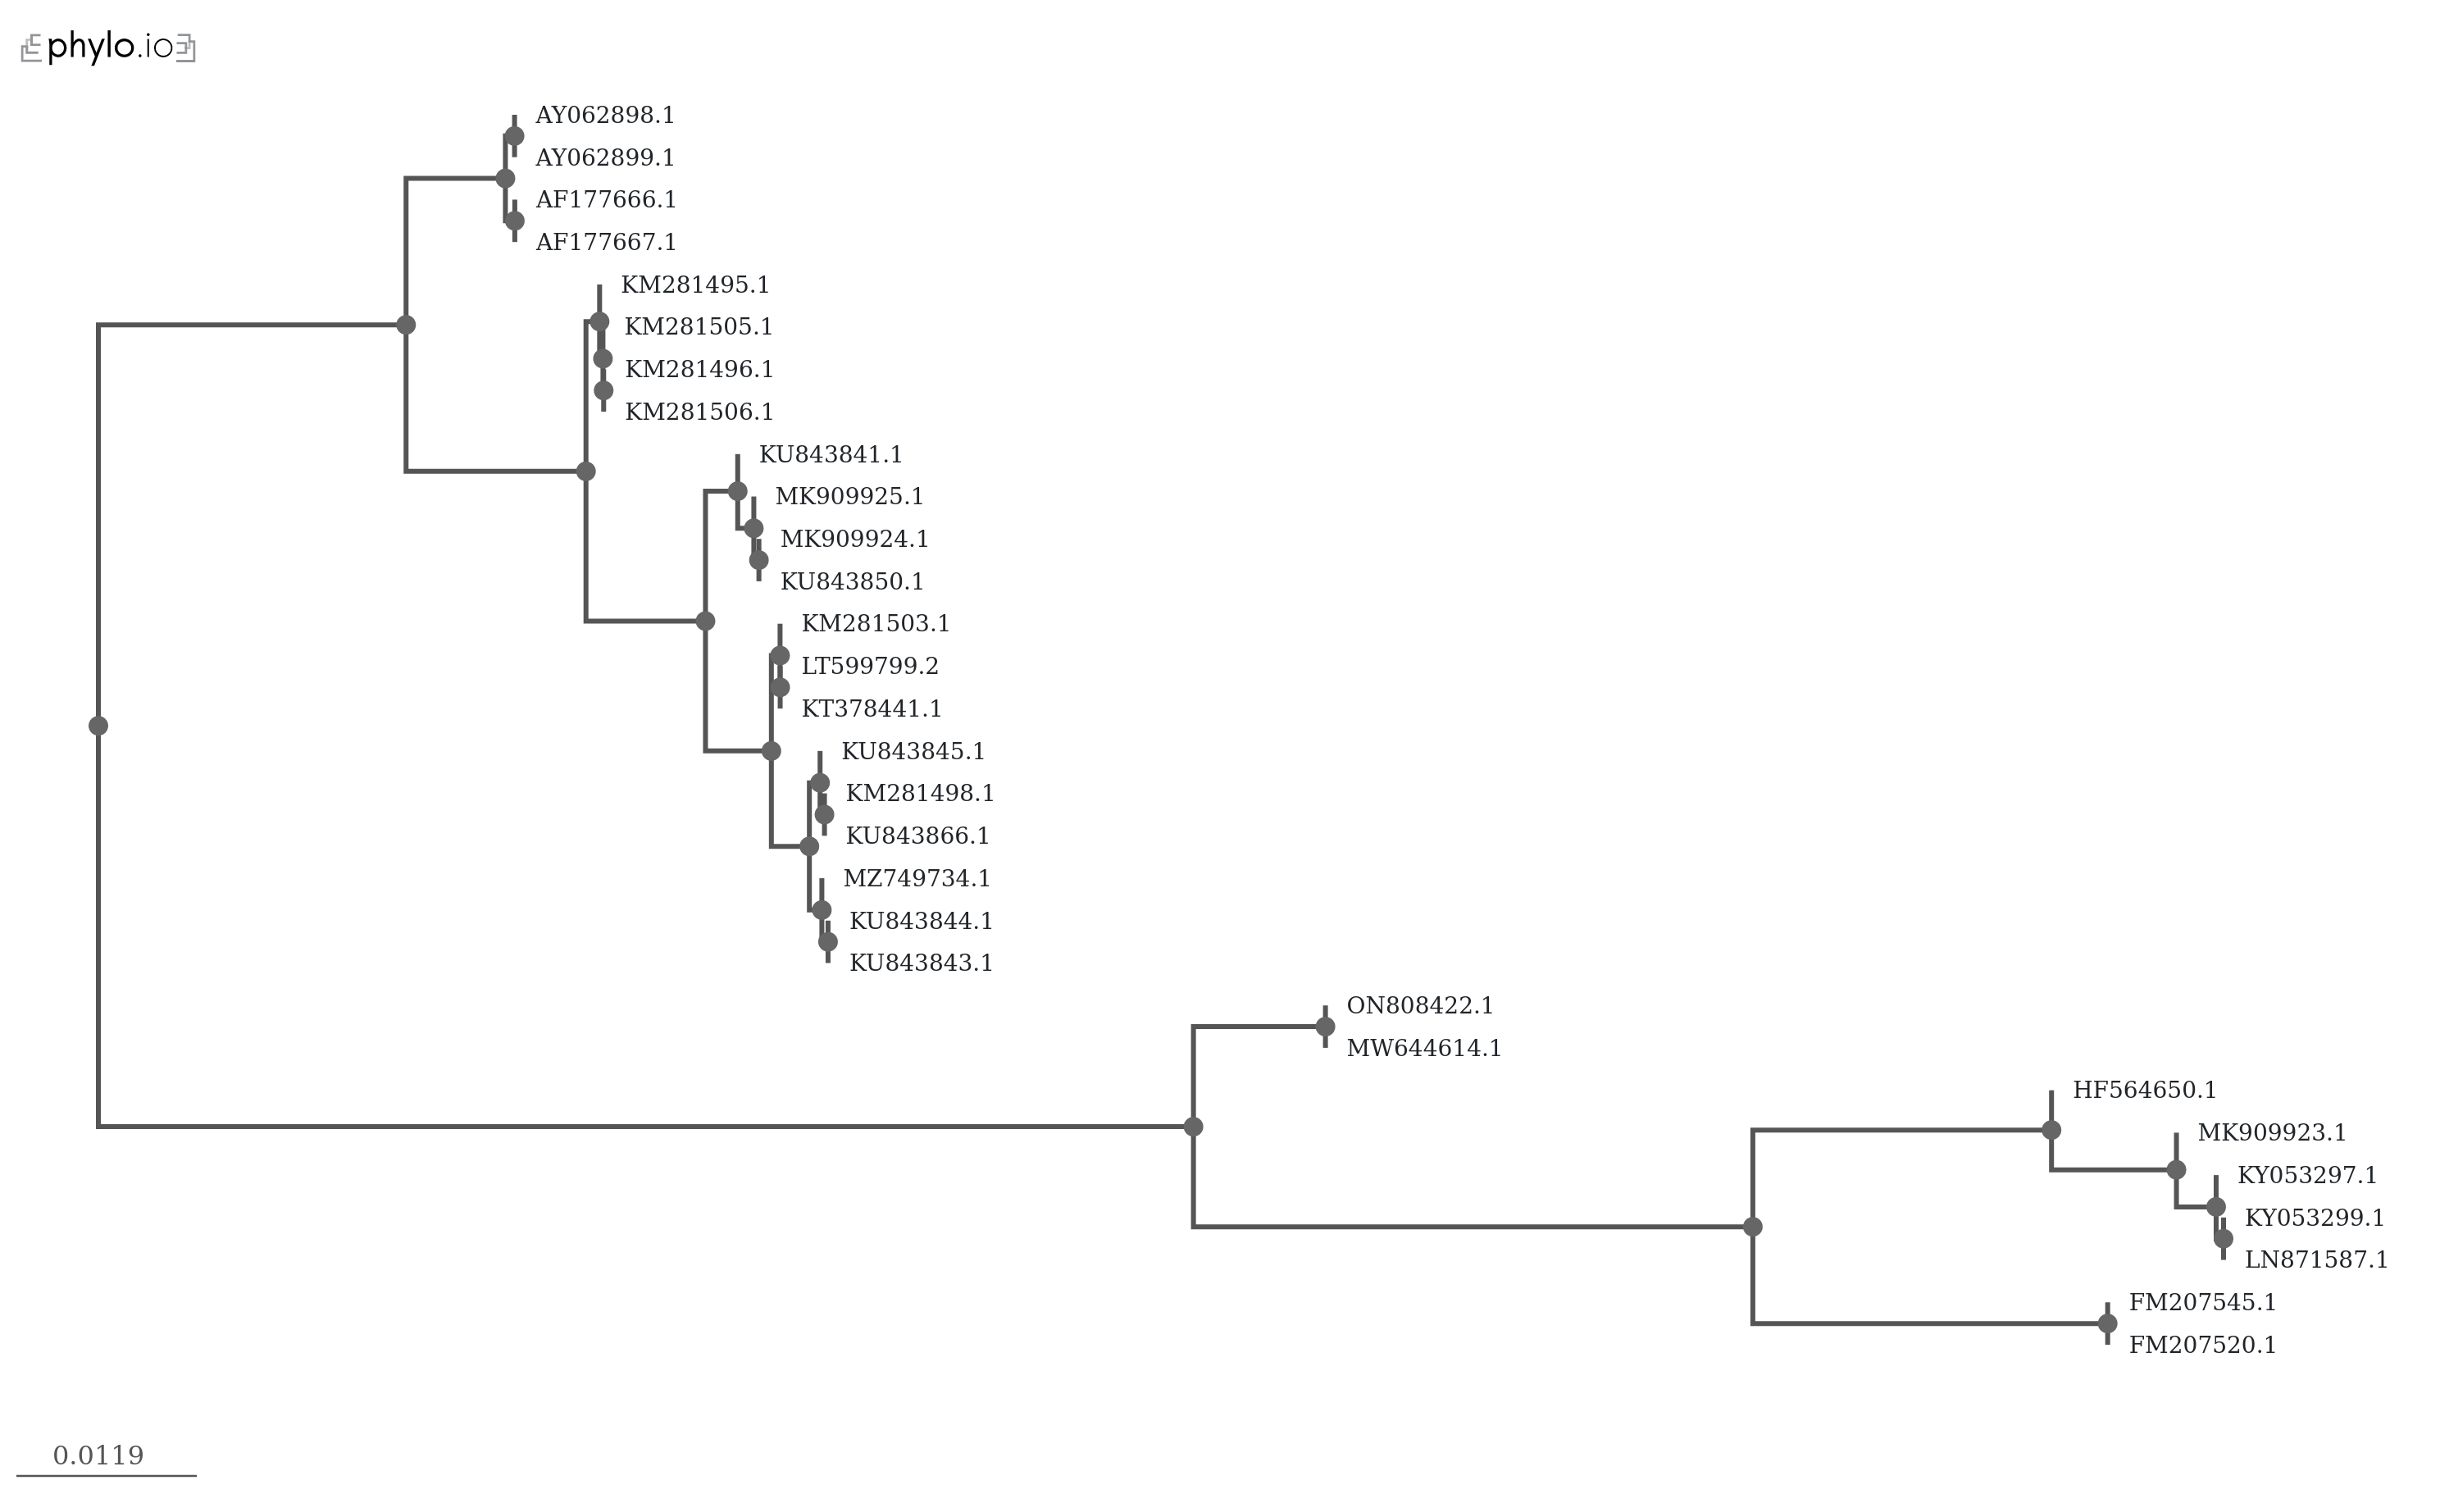

In [10]:
# Visualize the newick equivalent of the dendogram. The newick from above tree was visualizd in phylo.io
image_path = "./images/cosine_similarity/4_kmer_tree.png"
Image(filename=image_path)


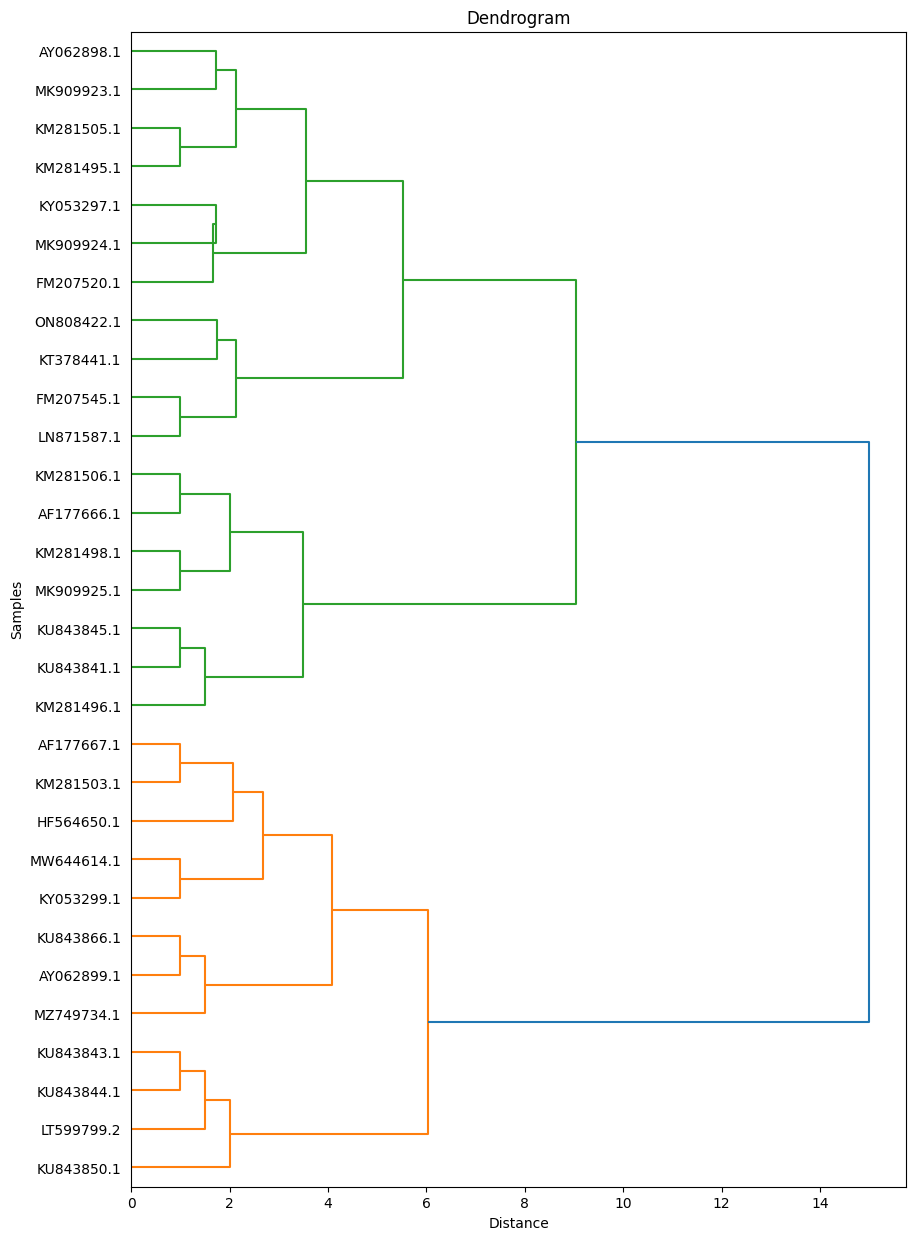

In [11]:
# Results for kmer = 9
data, newick_format_9_kmer = read_kmer_matrix_file("updated_data/cosine_similarity_9_mer.csv")

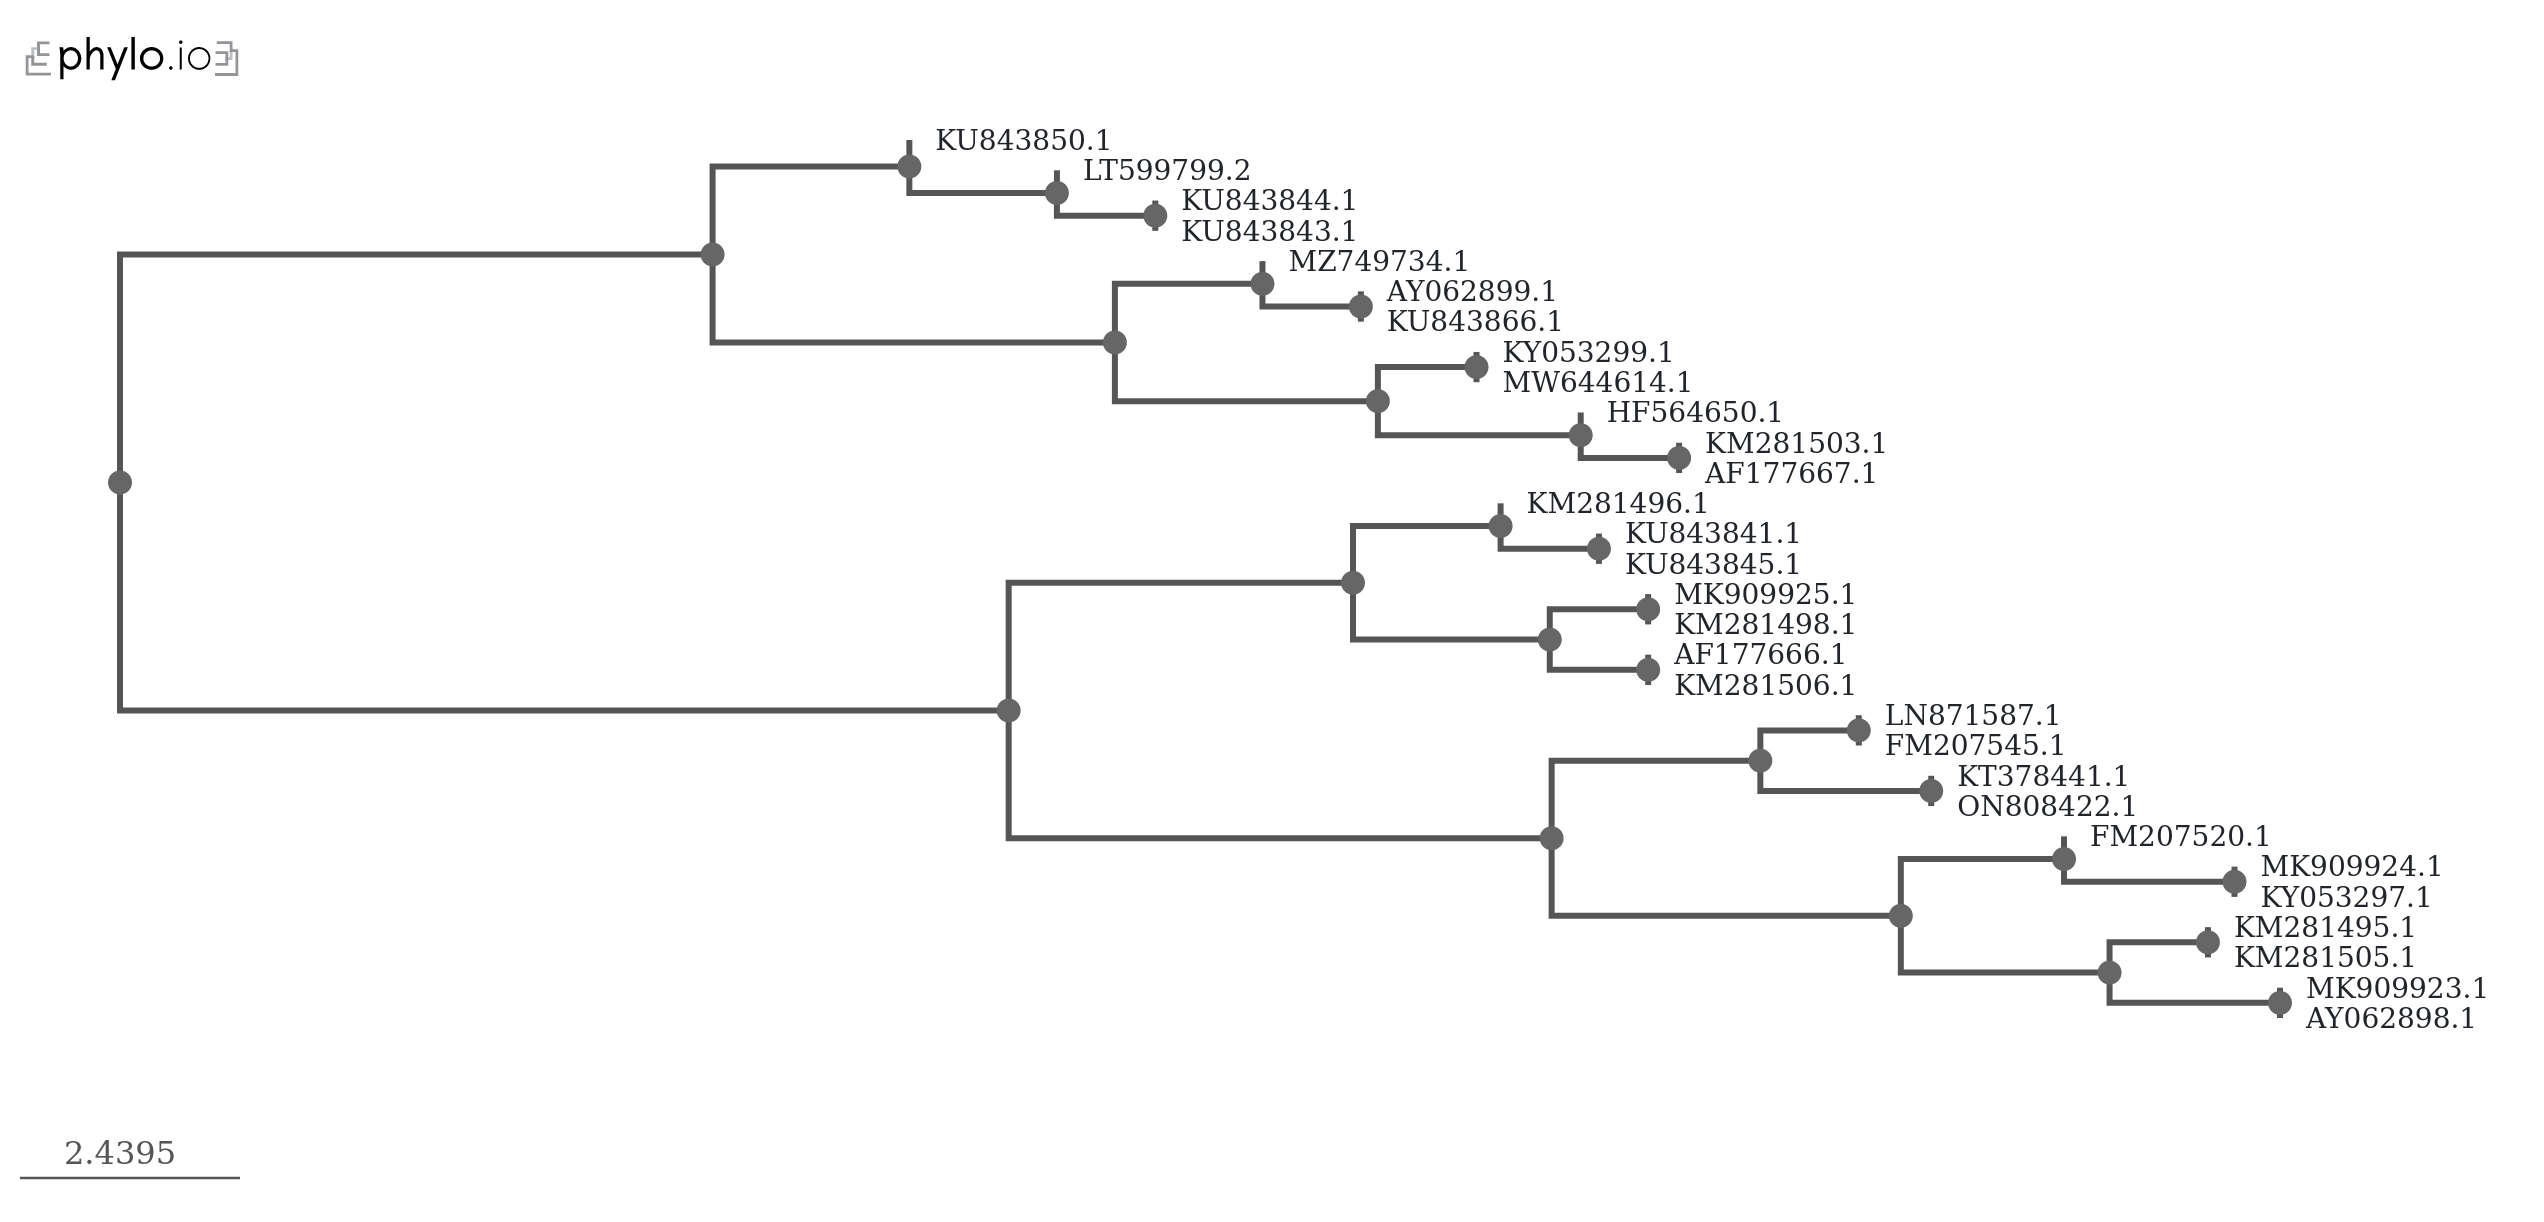

In [12]:
image_path = "./images/cosine_similarity/9_kmer_tree.png"
Image(filename=image_path)

# character level cosine Similarity


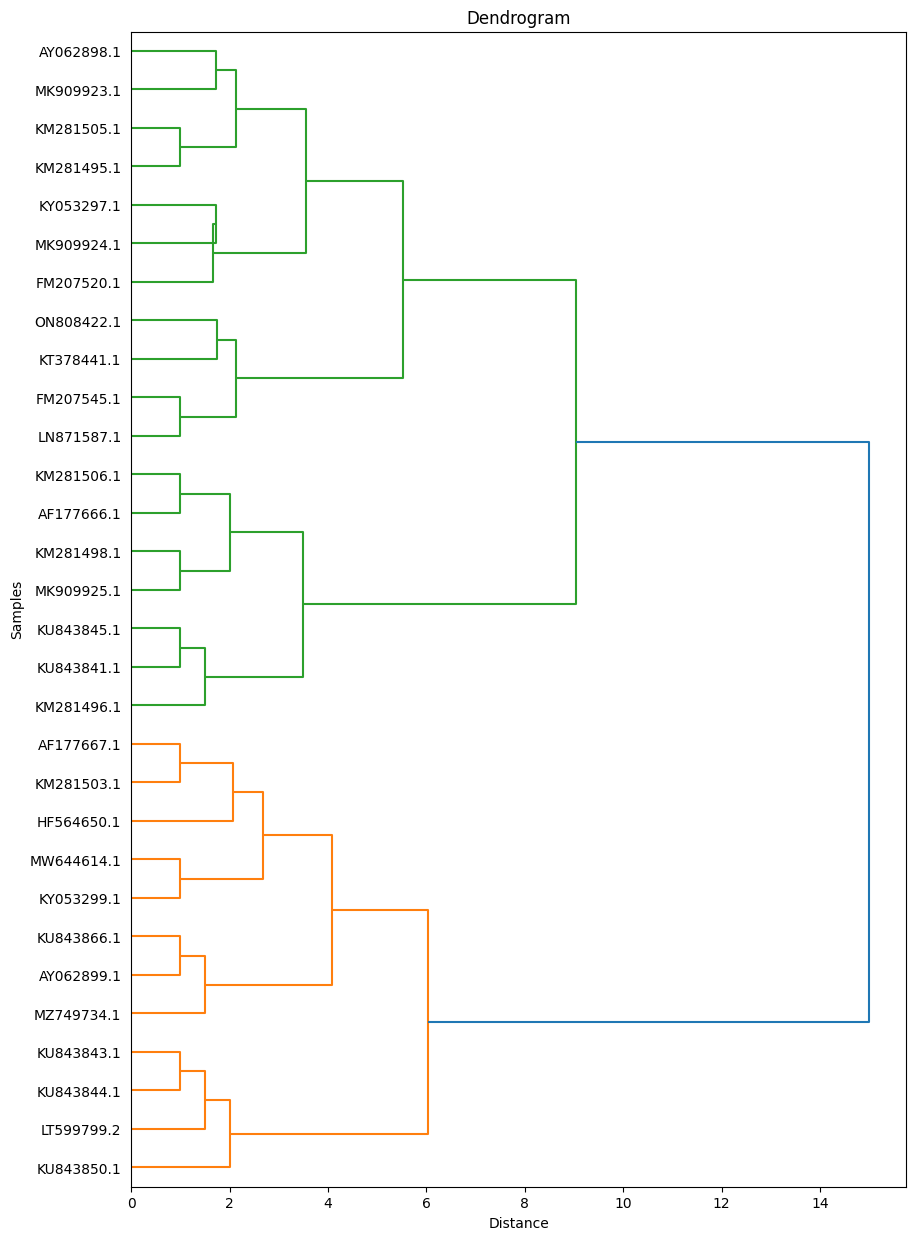

In [13]:
# Results for kmer = 5
data, newick_format_character = read_kmer_matrix_file("updated_data/cosine_similarity_6_mer.csv")


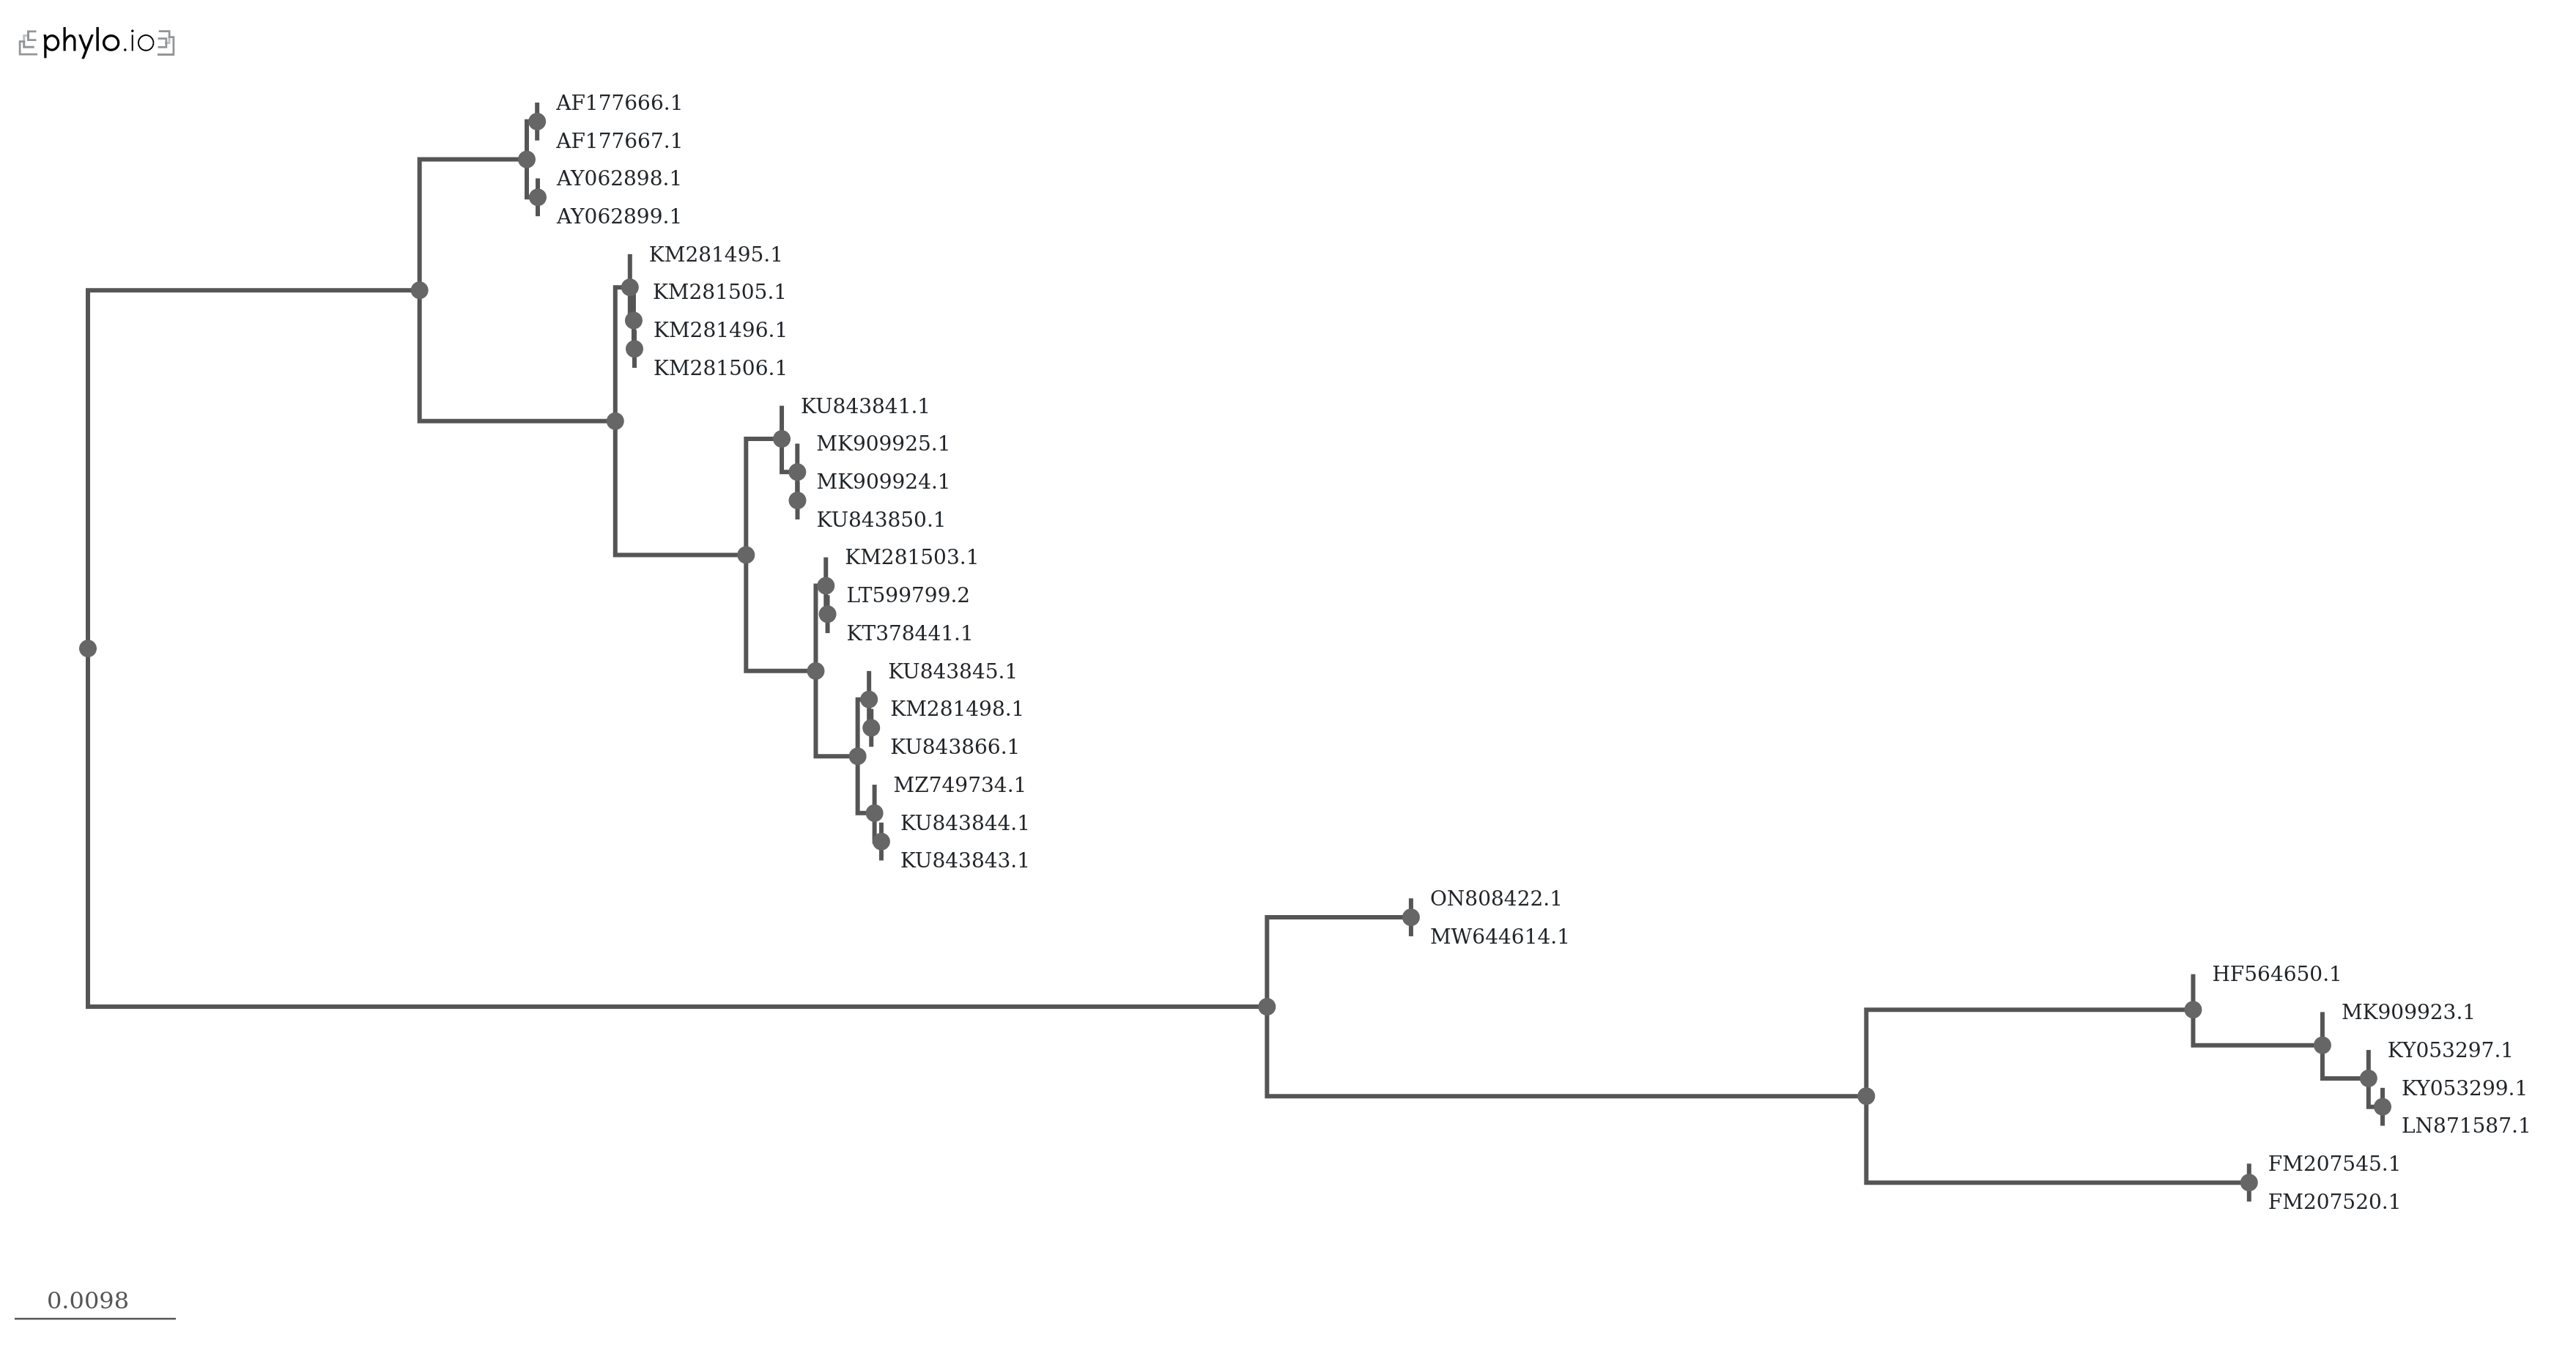

In [14]:
# Visualize the newick equivalent of the dendogram. The newick from above tree was visualizd in phylo.io
image_path = "./images/cosine_similarity/characteter_level.png"
Image(filename=image_path)


# Next steps
- Compare the clustering based tres  with the trees generated by Alignment methods e.g MAFFT, CLUSTAL
- Analyse the clustering patterns
- Try to reorder the sequences if this may affect the clustering
- Try different kmers ---Kmer=9 has been associated with the best results (added recommendation to load_multifasta_sequences.py)


In [15]:
# Compare with the trees generated by Alignment methods e.g mafft
# Analyse the clustering patterns
# 